# Multi-Objective Radioactive Decay Optimization

This notebook explores a multi-objective optimization problem derived from combining three 2D radioactive decay problems.
The objectives are combined using a convex combination with lambda coefficients.

We will:
1. Define the individual and combined loss functions.
2. Implement a function to find optimal parameters `x` for given lambdas using Differential Evolution.
3. Implement a function to compute the covariance matrix of optimal `x` under lambda perturbations.
4. Generate a dataset of (lambda, covariance_norm) pairs.
5. Visualize the relationship between lambdas, optimal `x`, and covariance norms.

In [ ]:
# Cell 1: Imports and Global Parameters
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For potential 3D plots
from joblib import Parallel, delayed
import time as pytime # To distinguish from the TIME variable

# --- Global parameters for the decay model ---
TIME_POINTS = 20  # Number of time points
TIME = np.linspace(0, 5, TIME_POINTS) # Time vector
Y1_INIT = 100  # Initial quantity for component 1
Y2_INIT = 100  # Initial quantity for component 2
LMBDA_REG = 1e-2  # Regularization parameter for individual loss functions

# --- "True" underlying decay constants for the three problems ---
# These define the individual objective functions.
X_TRUE1 = np.array([0.7, 0.3])
X_TRUE2 = np.array([0.4, 0.1])
X_TRUE3 = np.array([1.5, 0.5])

# --- Optimization parameters ---
OPTIMIZER_BOUNDS = [(0.0, 2.0), (0.0, 2.0)] # Domain for x = [x_a, x_b]
DE_MAX_ITER = 50 # Max iterations for differential_evolution
DE_TOL = 1e-3 # Tolerance for differential_evolution

# --- Covariance computation parameters ---
NUM_PERTURBATIONS = 10 # Number of perturbations for covariance estimation
PERTURBATION_STRENGTH = 0.05 # Strength of lambda perturbations
GLOBAL_SEED = 42 # Define a global seed for reproducibility

# --- Data generation parameters ---
NUM_LAMBDA_SAMPLES = 2000 # Number of base lambda vectors for dataset

# 1. Single Decay Problem Definition
Functions `forward_decay` and `loss_decay` define the simulation and loss for a single 2D radioactive decay problem.
`S_HAT1`, `S_HAT2`, `S_HAT3` are the "observed" data generated from the true parameters.

In [31]:
# Cell 2: Single Decay Problem Functions and S_HAT Generation
def forward_decay(x, time_vec, y1_init, y2_init):
    """
    Simulates the decay process.
    x: array of two decay constants [decay_1, decay_2]
    time_vec: numpy array of time points
    y1_init, y2_init: initial quantities
    Returns: sum of y1 and y2 over time_vec
    """
    y1 = y1_init * np.exp(-x[0] * time_vec)
    y2 = y2_init * np.exp(-x[1] * time_vec)
    s = y1 + y2
    return s

def loss_decay(x, s_hat, time_vec, y1_init, y2_init, lmbda_reg):
    """
    Calculates the loss for a single decay problem.
    x: current decay constants being evaluated
    s_hat: "observed" or target sum of decays
    lmbda_reg: regularization strength
    Returns: scalar loss value
    """
    s = forward_decay(x, time_vec, y1_init, y2_init)
    # Mean squared error + L2 regularization on x
    return np.mean((s - s_hat)**2) + lmbda_reg * np.linalg.norm(x)**2

# Generate "observed" data for each of the three problems
S_HAT1 = forward_decay(X_TRUE1, TIME, Y1_INIT, Y2_INIT)
S_HAT2 = forward_decay(X_TRUE2, TIME, Y1_INIT, Y2_INIT)
S_HAT3 = forward_decay(X_TRUE3, TIME, Y1_INIT, Y2_INIT)

print(f"S_HAT1 (first 5 points): {S_HAT1[:5]}")
print(f"S_HAT2 (first 5 points): {S_HAT2[:5]}")
print(f"S_HAT3 (first 5 points): {S_HAT3[:5]}")

S_HAT1 (first 5 points): [200.         175.58492373 154.57654909 136.45493928 120.7835925 ]
S_HAT2 (first 5 points): [200.         187.41150797 175.88872149 165.33015119 155.64431817]
S_HAT3 (first 5 points): [200.         155.05674053 122.27042504  97.98450002  79.69695422]


# 2. Multi-Objective Combined Loss Function
The `combined_loss` function calculates the total loss as a convex combination of the three individual losses.

In [32]:
# Cell 3: Multi-Objective Loss Function
def combined_loss(x, lambda_coeffs, s_hat1, s_hat2, s_hat3):
    """
    Calculates the combined loss for the multi-objective problem.
    x: parameters to optimize [x_a, x_b]
    lambda_coeffs: array [lambda_1, lambda_2, lambda_3], summing to 1
    s_hat1, s_hat2, s_hat3: observed data for the three problems
    Returns: scalar combined loss
    """
    loss1 = loss_decay(x, s_hat1, TIME, Y1_INIT, Y2_INIT, LMBDA_REG)
    loss2 = loss_decay(x, s_hat2, TIME, Y1_INIT, Y2_INIT, LMBDA_REG)
    loss3 = loss_decay(x, s_hat3, TIME, Y1_INIT, Y2_INIT, LMBDA_REG)
    
    return lambda_coeffs[0]*loss1 + lambda_coeffs[1]*loss2 + lambda_coeffs[2]*loss3

# Example: Test combined_loss
test_x = np.array([0.5, 0.5])
test_lambdas = np.array([0.33, 0.33, 0.34])
loss_val = combined_loss(test_x, test_lambdas, S_HAT1, S_HAT2, S_HAT3)
print(f"Test combined loss with x={test_x}, lambdas={test_lambdas}: {loss_val:.4f}")

Test combined loss with x=[0.5 0.5], lambdas=[0.33 0.33 0.34]: 1070.9478


# 3. Optimizer for a Given Lambda
`find_optimal_x` uses `scipy.optimize.differential_evolution` to find the optimal `x` that minimizes the `combined_loss` for a given set of `lambda_coeffs`.


In [33]:
# Cell 4: Optimizer function
def find_optimal_x(lambda_coeffs_tuple):
    """
    Finds the optimal x for a given set of lambda coefficients.
    lambda_coeffs_tuple: tuple (lambda_1, lambda_2, lambda_3)
    Returns: numpy array of optimal x parameters [x_opt_a, x_opt_b]
    """
    lambda_coeffs = np.array(lambda_coeffs_tuple)
    
    # Objective function for the optimizer (takes only x)
    objective_func = lambda x_params: combined_loss(x_params, lambda_coeffs, S_HAT1, S_HAT2, S_HAT3)
    
    # Run differential evolution
    result = opt.differential_evolution(
        objective_func, 
        bounds=OPTIMIZER_BOUNDS,
        maxiter=DE_MAX_ITER,
        tol=DE_TOL,
        workers=1 # Use all available cores for this optimization instance
    )
    return result.x

# Example: Test find_optimal_x
example_lambdas = (1/3, 1/3, 1/3)
start_time = pytime.time()
optimal_x_example = find_optimal_x(example_lambdas)
end_time = pytime.time()
print(f"Optimal x for lambdas {example_lambdas}: {optimal_x_example}, found in {end_time - start_time:.2f}s")


Optimal x for lambdas (0.3333333333333333, 0.3333333333333333, 0.3333333333333333): [0.90318589 0.20947818], found in 0.14s


# 4. Covariance Matrix Computation
`generate_perturbed_lambdas` creates slight variations of a given lambda vector.
`compute_covariance_for_lambda` calculates the covariance matrix of optimal `x` values obtained from these perturbed lambdas. This step is parallelized using `joblib`.

In [34]:
def generate_perturbed_lambdas(lambda_vec, num_perturbations, strength, rng):
    """
    Generates perturbed lambda vectors around a central lambda_vec using a provided RNG.
    All generated vectors are normalized to sum to 1 and clipped to [0,1].
    rng: An instance of numpy.random.Generator for deterministic random number generation.
    """
    perturbed_lambdas_list = []
    base_lambda = np.array(lambda_vec)
    
    # Generate a fixed set of unique perturbations based on the rng state
    # To ensure num_perturbations are distinct if possible, we might need more attempts
    # or a different strategy if strength is very low or num_perturbations is high.
    # For simplicity, we generate and then take unique ones.
    
    generated_count = 0
    attempts = 0
    max_attempts = num_perturbations * 5 # Try more times to get unique perturbations

    temp_perturbed_lambdas = []

    while generated_count < num_perturbations and attempts < max_attempts:
        perturbation = rng.normal(0, strength, 3)
        # The original 'while np.all(perturbation == 0)' loop is unlikely with rng.normal
        # but good to be mindful of extremely small strengths.
        # If strength is 0, this will always be base_lambda.

        perturbed = base_lambda + perturbation
        perturbed = np.clip(perturbed, 0, 1)  # Ensure lambdas are in [0,1]
        
        sum_perturbed = np.sum(perturbed)
        if sum_perturbed == 0:
            # This case happens if all components are clipped to 0.
            # A deterministic outcome if base_lambda + perturbation leads to all <=0.
            perturbed = np.ones(3) / 3.0
        else:
            perturbed /= sum_perturbed
            
        temp_perturbed_lambdas.append(tuple(perturbed))
        generated_count +=1
        attempts +=1
    
    # Use set to remove duplicates, then convert back to list
    # Sort to ensure order is deterministic if content is the same across runs
    perturbed_lambdas_list = sorted(list(set(temp_perturbed_lambdas)))

    # If we still don't have enough unique perturbations, we might return fewer.
    # Or, one could add the base_lambda itself if not present.
    if not perturbed_lambdas_list and num_perturbations > 0: # If list is empty but we wanted some
        perturbed_lambdas_list.append(tuple(base_lambda / np.sum(base_lambda))) # Add normalized base as a fallback

    return perturbed_lambdas_list[:num_perturbations] # Return up to num_perturbations


# Wrapper for find_optimal_x to control its 'workers' and 'seed' parameter
def find_optimal_x_for_cov_wrapper(lambda_coeffs_tuple, workers_for_de, seed_for_optimizer):
    """
    Finds optimal x for given lambdas, using a specific seed for the optimizer.
    seed_for_optimizer: Seed for the differential_evolution algorithm.
    """
    lambda_coeffs = np.array(lambda_coeffs_tuple)
    objective_func = lambda x_params: combined_loss(x_params, lambda_coeffs, S_HAT1, S_HAT2, S_HAT3)
    
    result = opt.differential_evolution(
        objective_func, 
        bounds=OPTIMIZER_BOUNDS,
        maxiter=DE_MAX_ITER,
        tol=DE_TOL,
        workers=workers_for_de,
        seed=seed_for_optimizer # Added seed for determinism
    )
    return result.x

def compute_covariance_for_lambda(lambda_vec_tuple, n_jobs=-1, base_seed=None):
    """
    Computes the covariance matrix of optimal x values for perturbed lambdas, deterministically.
    lambda_vec_tuple: The central lambda vector (tuple).
    n_jobs: Number of parallel jobs for optimization runs.
    base_seed: Seed to initialize the random number generator for perturbations
               and to derive seeds for the optimizer. If None, behavior might be stochastic.
    Returns: (covariance_matrix, norm_of_covariance_matrix)
    """
    lambda_vec = np.array(lambda_vec_tuple)
    
    # Initialize RNG for generating perturbations
    # If base_seed is None, np.random.default_rng() uses system entropy, making it non-deterministic.
    # For full determinism, a base_seed should always be provided.
    rng = np.random.default_rng(base_seed)
    
    perturbed_lambdas_list = generate_perturbed_lambdas(lambda_vec, NUM_PERTURBATIONS, PERTURBATION_STRENGTH, rng)
    
    if not perturbed_lambdas_list:
        # print(f"Warning: No valid perturbations for lambda {lambda_vec_tuple} with seed {base_seed}")
        return np.zeros((2,2)), 0.0

    # Prepare arguments for parallel execution, ensuring each job gets a deterministic seed
    # The seed for each optimizer call is derived from base_seed.
    # Using enumerate to get an index for deriving unique seeds for each parallel job.
    # Note: joblib's delayed function captures arguments at definition time.
    
    tasks = []
    for i, pl_coeffs in enumerate(perturbed_lambdas_list):
        # Derive a unique, deterministic seed for each optimization run
        optimizer_seed_for_this_task = base_seed + i + 1 if base_seed is not None else None
        tasks.append(delayed(find_optimal_x_for_cov_wrapper)(pl_coeffs, workers_for_de=1, seed_for_optimizer=optimizer_seed_for_this_task))

    optimal_xs_for_perturbations = Parallel(n_jobs=n_jobs)(tasks)
    
    optimal_xs_array = np.array(optimal_xs_for_perturbations)
    
    if optimal_xs_array.shape[0] < 2:
        # print(f"Warning: Less than 2 optimal_xs samples for lambda {lambda_vec_tuple}, shape {optimal_xs_array.shape}")
        return np.full((2,2), np.nan), np.nan

    try:
        # rowvar=False because each row of optimal_xs_array is an observation (an x-vector),
        # and columns are the variables (x[0], x[1]).
        cov_matrix = np.cov(optimal_xs_array, rowvar=False) 
    except Exception as e:
        print(f"Error computing covariance for {lambda_vec_tuple} with base_seed {base_seed}: {e}")
        print(f"Optimal_xs_array shape: {optimal_xs_array.shape}, content: {optimal_xs_array}")
        return np.full((2,2), np.nan), np.nan

    norm_cov = np.linalg.norm(cov_matrix)
    return cov_matrix, norm_cov


# Example: Test covariance computation with determinism
print("--- Testing Deterministic Covariance Computation ---")
example_lambdas_cov = (0.5, 0.3, 0.2)

# --- First run ---
start_time_run1 = pytime.time()
cov_mat_run1, norm_val_run1 = compute_covariance_for_lambda(
    example_lambdas_cov, 
    n_jobs=2, # Adjust n_jobs as per your system
    base_seed=GLOBAL_SEED # Use the defined global seed
)
end_time_run1 = pytime.time()
print(f"Run 1 with seed {GLOBAL_SEED}:")
print(f"Covariance matrix:\n{cov_mat_run1}")
print(f"Norm of covariance: {norm_val_run1:.6f}")
print(f"Time: {end_time_run1 - start_time_run1:.2f}s")

# --- Second run with the same seed ---
start_time_run2 = pytime.time()
cov_mat_run2, norm_val_run2 = compute_covariance_for_lambda(
    example_lambdas_cov, 
    n_jobs=2, 
    base_seed=GLOBAL_SEED # Use the SAME global seed
)
end_time_run2 = pytime.time()
print(f"\nRun 2 with seed {GLOBAL_SEED}:")
print(f"Covariance matrix:\n{cov_mat_run2}")
print(f"Norm of covariance: {norm_val_run2:.6f}")
print(f"Time: {end_time_run2 - start_time_run2:.2f}s")

# --- Third run with a different seed ---
start_time_run3 = pytime.time()
cov_mat_run3, norm_val_run3 = compute_covariance_for_lambda(
    example_lambdas_cov, 
    n_jobs=2, 
    base_seed=GLOBAL_SEED + 100 # Use a DIFFERENT seed
)
end_time_run3 = pytime.time()
print(f"\nRun 3 with seed {GLOBAL_SEED + 100}:")
print(f"Covariance matrix:\n{cov_mat_run3}")
print(f"Norm of covariance: {norm_val_run3:.6f}")
print(f"Time: {end_time_run3 - start_time_run3:.2f}s")


# Check if Run 1 and Run 2 are identical
if np.allclose(cov_mat_run1, cov_mat_run2) and np.isclose(norm_val_run1, norm_val_run2):
    print("\nSUCCESS: Run 1 and Run 2 are identical, demonstrating determinism with the same seed.")
else:
    print("\nWARNING: Run 1 and Run 2 are NOT identical. Determinism issue might persist.")
    print("Diff norm_val:", abs(norm_val_run1 - norm_val_run2))
    print("Diff cov_mat:\n", cov_mat_run1 - cov_mat_run2)


# Check if Run 1 and Run 3 are different (expected)
if not np.allclose(cov_mat_run1, cov_mat_run3) or not np.isclose(norm_val_run1, norm_val_run3):
    print("\nSUCCESS: Run 1 and Run 3 (different seeds) produce different results, as expected.")
else:
    print("\nWARNING: Run 1 and Run 3 (different seeds) are identical. This might be coincidental or indicate an issue if strong differences were expected.")



--- Testing Deterministic Covariance Computation ---
Run 1 with seed 42:
Covariance matrix:
[[ 0.09460006 -0.09661263]
 [-0.09661263  0.09970473]]
Norm of covariance: 0.193799
Time: 8.71s

Run 2 with seed 42:
Covariance matrix:
[[ 0.09460006 -0.09661263]
 [-0.09661263  0.09970473]]
Norm of covariance: 0.193799
Time: 0.14s

Run 3 with seed 142:
Covariance matrix:
[[ 0.0897721  -0.09458908]
 [-0.09458908  0.10233096]]
Norm of covariance: 0.190853
Time: 0.14s

SUCCESS: Run 1 and Run 2 are identical, demonstrating determinism with the same seed.

SUCCESS: Run 1 and Run 3 (different seeds) produce different results, as expected.


# 5. Lambda Sample Generation
`generate_lambda_samples` creates a list of diverse lambda coefficient sets. These will form the basis of our dataset.

In [35]:
# Cell 6: Lambda Sample Generation
def generate_lambda_samples(num_samples):
    """
    Generates diverse lambda samples that sum to 1.
    Uses Dirichlet distribution properties for more uniform sampling on the simplex.
    """
    samples = []
    # Generate samples using random numbers and normalization
    # y_i = -log(u_i), where u_i ~ U(0,1)
    # lambda_i = y_i / sum(y_j)
    raw_samples = -np.log(np.random.rand(num_samples, 3))
    for sample in raw_samples:
        samples.append(tuple(sample / np.sum(sample)))
    
    # Add some specific boundary and central cases for better coverage
    samples.append((1.0, 0.0, 0.0))
    samples.append((0.0, 1.0, 0.0))
    samples.append((0.0, 0.0, 1.0))
    samples.append((0.5, 0.5, 0.0))
    samples.append((0.5, 0.0, 0.5))
    samples.append((0.0, 0.5, 0.5))
    samples.append((1/3, 1/3, 1/3))
    
    return list(set(samples)) # Remove duplicates

lambda_coeffs_list = generate_lambda_samples(NUM_LAMBDA_SAMPLES)
print(f"Generated {len(lambda_coeffs_list)} unique lambda samples.")
print("First 5 samples:", lambda_coeffs_list[:5])

Generated 107 unique lambda samples.
First 5 samples: [(np.float64(0.0024219568998599906), np.float64(0.4888748133739633), np.float64(0.5087032297261768)), (np.float64(0.5406218282753841), np.float64(0.4571676804901264), np.float64(0.0022104912344895374)), (np.float64(0.5376643887792866), np.float64(0.2199530688722355), np.float64(0.24238254234847792)), (np.float64(0.8357856807520913), np.float64(0.12928624753678972), np.float64(0.03492807171111903)), (np.float64(0.21658716807161138), np.float64(0.7683528906096547), np.float64(0.015059941318733956))]


# 6. Main Data Generation Loop
This loop iterates through the generated lambda samples, computes the optimal `x` and the norm of the covariance matrix for each.
The results are stored for later plotting.
*This cell can take a significant amount of time to run.*

In [36]:
# Cell 7: Main Data Generation Loop
dataset = [] # To store (lambda_coeffs, optimal_x, norm_covariance)

# For storing data for plots
lambdas_plot = [] # Store (l1, l2) for plotting
optimal_x0_plot = []
optimal_x1_plot = []
covariance_norms_plot = []

print(f"Starting data generation for {len(lambda_coeffs_list)} lambda samples...")
total_start_time = pytime.time()

for i, lambda_c in enumerate(lambda_coeffs_list):
    iter_start_time = pytime.time()
    print(f"Processing lambda sample {i+1}/{len(lambda_coeffs_list)}: {np.round(lambda_c,3)}...")
    
    # a. Find optimal x for the current lambda_c
    # Use the original find_optimal_x which can use multiple workers internally
    current_optimal_x = find_optimal_x(lambda_c) 
    
    # b. Compute covariance matrix and its norm
    # compute_covariance_for_lambda itself uses Parallel for its internal loop,
    # and calls a version of find_optimal_x that uses workers=1.
    # Set n_jobs for compute_covariance_for_lambda (e.g. 2 or based on available cores)
    _, current_norm_cov = compute_covariance_for_lambda(lambda_c, n_jobs=2) 
    
    # c. Store results
    dataset.append({
        "lambdas": lambda_c,
        "optimal_x": current_optimal_x,
        "norm_covariance": current_norm_cov
    })
    
    # For easier plotting later
    if not np.isnan(current_norm_cov): # Only plot valid results
        lambdas_plot.append((lambda_c[0], lambda_c[1])) # Using (l1, l2) for 2D plot
        optimal_x0_plot.append(current_optimal_x[0])
        optimal_x1_plot.append(current_optimal_x[1])
        covariance_norms_plot.append(current_norm_cov)
    
    iter_end_time = pytime.time()
    print(f"  Finished sample {i+1}. Optimal x: {np.round(current_optimal_x,3)}, Cov Norm: {current_norm_cov:.4f}. Time: {iter_end_time - iter_start_time:.2f}s")

total_end_time = pytime.time()
print(f"\nData generation complete. Total time: {total_end_time - total_start_time:.2f}s")
print(f"Collected data for {len(lambdas_plot)} valid samples.")

# Convert plot data to numpy arrays
lambdas_plot_arr = np.array(lambdas_plot)
optimal_x0_plot_arr = np.array(optimal_x0_plot)
optimal_x1_plot_arr = np.array(optimal_x1_plot)
covariance_norms_plot_arr = np.array(covariance_norms_plot)


Starting data generation for 107 lambda samples...
Processing lambda sample 1/107: [0.002 0.489 0.509]...
  Finished sample 1. Optimal x: [1.011 0.182], Cov Norm: 0.3173. Time: 0.16s
Processing lambda sample 2/107: [0.541 0.457 0.002]...
  Finished sample 2. Optimal x: [0.602 0.171], Cov Norm: 0.0936. Time: 0.16s
Processing lambda sample 3/107: [0.538 0.22  0.242]...
  Finished sample 3. Optimal x: [0.856 0.236], Cov Norm: 0.1805. Time: 0.15s
Processing lambda sample 4/107: [0.836 0.129 0.035]...
  Finished sample 4. Optimal x: [0.712 0.254], Cov Norm: 0.0462. Time: 0.17s
Processing lambda sample 5/107: [0.217 0.768 0.015]...
  Finished sample 5. Optimal x: [0.121 0.501], Cov Norm: 0.0794. Time: 0.23s
Processing lambda sample 6/107: [0.384 0.226 0.39 ]...
  Finished sample 6. Optimal x: [0.247 0.982], Cov Norm: 0.2946. Time: 0.17s
Processing lambda sample 7/107: [0.442 0.488 0.07 ]...
  Finished sample 7. Optimal x: [0.164 0.642], Cov Norm: 0.1281. Time: 0.16s
Processing lambda sample 

# 7. Plotting Results
We'll create scatter plots to visualize:
- Lambda coefficients vs. Optimal `x` components (`x_opt[0]` and `x_opt[1]`).
- Lambda coefficients vs. Norm of the covariance matrix.

Lambda coefficients `(l1, l2, l3)` sum to 1, so we can represent them on a 2D plot using `l1` and `l2` (since `l3 = 1 - l1 - l2`). The valid region is a triangle.

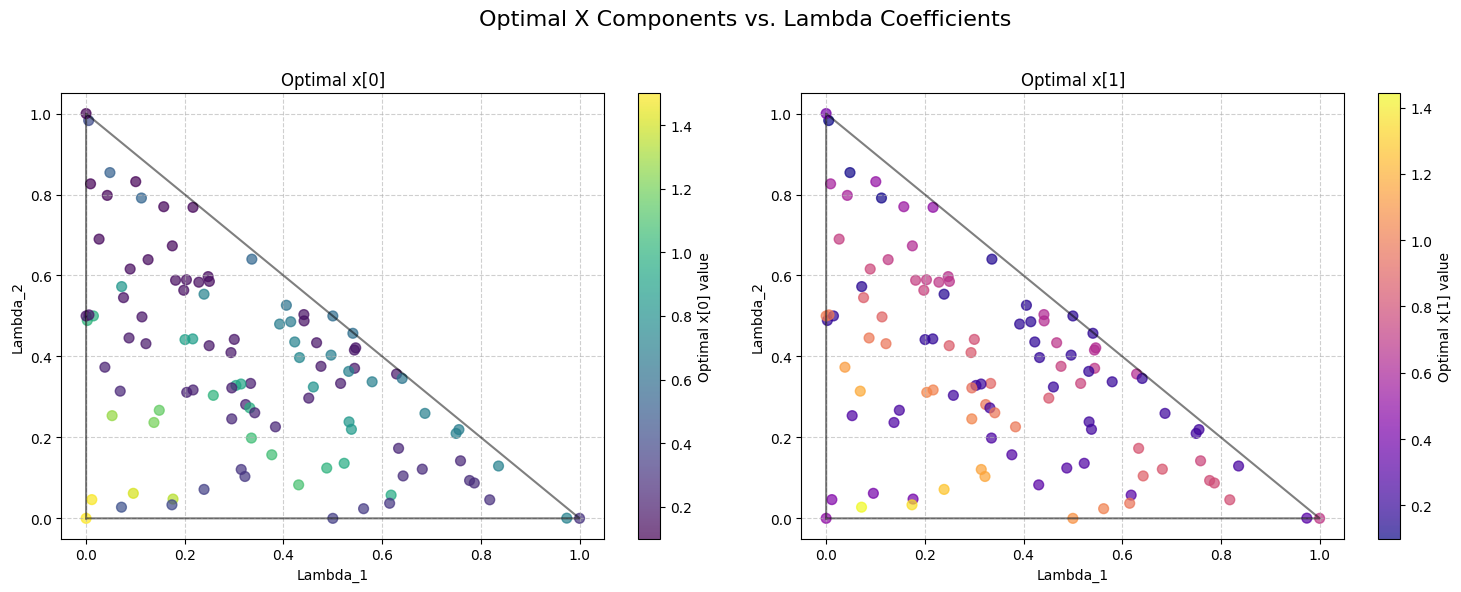

In [37]:
# Cell 8: Plotting - Lambda vs. Optimal X components

if len(lambdas_plot_arr) > 0:
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Optimal X Components vs. Lambda Coefficients', fontsize=16)

    # Scatter plot for x_optimal[0]
    sc0 = axs[0].scatter(lambdas_plot_arr[:, 0], lambdas_plot_arr[:, 1], c=optimal_x0_plot_arr, cmap='viridis', s=50, alpha=0.7)
    axs[0].set_xlabel('Lambda_1')
    axs[0].set_ylabel('Lambda_2')
    axs[0].set_title('Optimal x[0]')
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].set_xlim(-0.05, 1.05)
    axs[0].set_ylim(-0.05, 1.05)
    # Triangle boundary for l1+l2 <= 1
    axs[0].plot([0,1,0,0], [0,0,1,0], 'k-', alpha=0.5) 
    fig.colorbar(sc0, ax=axs[0], label='Optimal x[0] value')

    # Scatter plot for x_optimal[1]
    sc1 = axs[1].scatter(lambdas_plot_arr[:, 0], lambdas_plot_arr[:, 1], c=optimal_x1_plot_arr, cmap='plasma', s=50, alpha=0.7)
    axs[1].set_xlabel('Lambda_1')
    axs[1].set_ylabel('Lambda_2')
    axs[1].set_title('Optimal x[1]')
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].set_xlim(-0.05, 1.05)
    axs[1].set_ylim(-0.05, 1.05)
    axs[1].plot([0,1,0,0], [0,0,1,0], 'k-', alpha=0.5)
    fig.colorbar(sc1, ax=axs[1], label='Optimal x[1] value')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()
else:
    print("No valid data to plot for Optimal X components.")

# 8. Plotting - Lambda vs. Covariance Norm

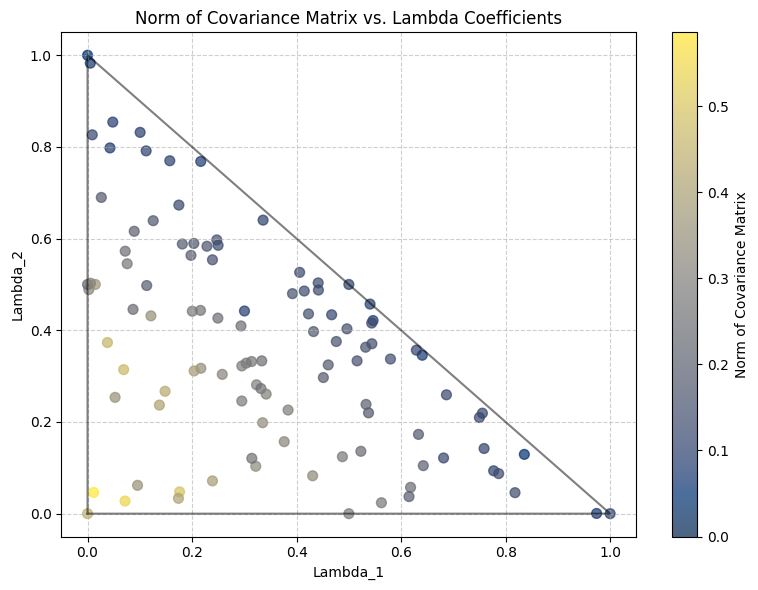

In [38]:
# Cell 9: Plotting - Lambda vs. Covariance Norm

if len(lambdas_plot_arr) > 0:
    plt.figure(figsize=(8, 6))
    sc_cov = plt.scatter(lambdas_plot_arr[:, 0], lambdas_plot_arr[:, 1], c=covariance_norms_plot_arr, cmap='cividis', s=50, alpha=0.7, vmin=0) # vmin=0 for norm
    plt.xlabel('Lambda_1')
    plt.ylabel('Lambda_2')
    plt.title('Norm of Covariance Matrix vs. Lambda Coefficients')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.plot([0,1,0,0], [0,0,1,0], 'k-', alpha=0.5) # Triangle boundary
    plt.colorbar(sc_cov, label='Norm of Covariance Matrix')
    plt.tight_layout()
    plt.show()
else:
    print("No valid data to plot for Covariance Norms.")

# 9. Gaussian Process Modeling of Covariance Norm

In this section, we will:
1. Split the generated (lambda, covariance_norm) data into training and testing sets.
2. Standardize the features (lambda pairs) and target (covariance norm).
3. Train a Gaussian Process Regressor model on the training data.
4. Evaluate the model on the test data.
5. Visualize the GP model's predictions:
   - A 3D surface plot of the predicted covariance norm over the lambda simplex, with test points overlaid.
   - A 2D plot of true vs. predicted covariance norms for the test set.

In [39]:
# Cell 10: Imports for GP Modeling and Plotting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm # For colormaps

# Ensure previous data is available (these would be outputs from Cell 7)
# For standalone execution, let's create some dummy data matching the expected structure
# In a real notebook, you would use the actual `lambdas_plot_arr` and `covariance_norms_plot_arr`
if 'lambdas_plot_arr' not in globals() or 'covariance_norms_plot_arr' not in globals() or len(lambdas_plot_arr) == 0:
    print("Warning: Using dummy data for GP modeling as 'lambdas_plot_arr' or 'covariance_norms_plot_arr' not found or empty.")
    _num_dummy_samples = 100
    _rng_dummy = np.random.default_rng(42)
    lambdas_plot_arr = _rng_dummy.random((_num_dummy_samples, 2))
    # Ensure dummy lambdas are in simplex: l1+l2 <= 1
    lambdas_plot_arr = lambdas_plot_arr[lambdas_plot_arr.sum(axis=1) <=1]
    covariance_norms_plot_arr = np.sin(lambdas_plot_arr[:,0]*np.pi) * np.cos(lambdas_plot_arr[:,1]*np.pi) + _rng_dummy.normal(0, 0.1, len(lambdas_plot_arr))
    if len(lambdas_plot_arr) == 0: # Fallback if all random points were outside simplex
         lambdas_plot_arr = np.array([[0.1,0.1],[0.5,0.2],[0.2,0.5]])
         covariance_norms_plot_arr = np.array([0.5,0.3,0.8])

## 9.1 Data Splitting and Preprocessing

In [40]:
# Cell 11: Data Splitting and Scaling
# Features: lambda_1, lambda_2
X_data = lambdas_plot_arr 
# Target: norm_covariance
y_data = covariance_norms_plot_arr.reshape(-1, 1) # Reshape for scaler

if len(X_data) < 10: # Need enough data for a meaningful split
    print(f"Warning: Very few data points ({len(X_data)}). Using all data for training and testing.")
    X_train, X_test, y_train, y_test = X_data, X_data, y_data, y_data
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.25, random_state=GLOBAL_SEED # Use GLOBAL_SEED for reproducibility
    )

# Scale features (lambdas)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target (covariance_norm)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
# y_test is scaled later for error metrics if needed, but usually we predict then inverse_transform

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 80
Test set size: 27


## 9.2 Gaussian Process Model Training

In [41]:
# Cell 12: GP Model Definition and Training

# Define the kernel for the GP
# RBF kernel for smoothness, ConstantKernel for scaling variance, WhiteKernel for noise
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2)) + \
         WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))

gp_model = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10, # Number of times the optimizer is restarted
    alpha=1e-5, # Small value added to diagonal of kernel matrix for stability
    random_state=GLOBAL_SEED # For reproducibility of optimizer
)

print("Training Gaussian Process Regressor...")
start_gp_train_time = pytime.time()
gp_model.fit(X_train_scaled, y_train_scaled)
end_gp_train_time = pytime.time()
print(f"GP training completed in {end_gp_train_time - start_gp_train_time:.2f}s")
print(f"Optimized kernel: {gp_model.kernel_}")

Training Gaussian Process Regressor...
GP training completed in 0.38s
Optimized kernel: 1.77**2 * RBF(length_scale=2.73) + WhiteKernel(noise_level=0.0897)


## 9.3 Model Prediction and Evaluation

In [42]:
# Cell 13: Prediction and Evaluation
y_pred_scaled, y_std_scaled = gp_model.predict(X_test_scaled, return_std=True)

# Inverse transform predictions and std
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
# Standard deviation needs to be scaled by the target scaler's scale, not inverse_transformed directly
y_std = y_std_scaled * scaler_y.scale_ 

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation on Test Set:")
print(f"  Mean Squared Error (MSE): {mse:.4f}")
print(f"  R-squared (R2 Score): {r2:.4f}")

# Absolute errors for coloring test points in 3D plot
test_errors = np.abs(y_test.ravel() - y_pred.ravel())



Model Evaluation on Test Set:
  Mean Squared Error (MSE): 0.0018
  R-squared (R2 Score): 0.8966


## 9.4 Visualization Functions

In [43]:
# Cell 14: Plotting Functions (Adapted and Enhanced)

def plot_gp_surface_with_test_points_enhanced(model, X_train_orig, y_train_orig, X_test_orig, y_test_orig, 
                                              y_pred_test, test_point_errors, scaler_X_fitted, scaler_y_fitted,
                                              title_suffix="Covariance Norm"):
    """
    Plot the GP model surface, training points, and test points (colored by error).
    X_train_orig, y_train_orig, X_test_orig, y_test_orig are unscaled original values.
    y_pred_test are unscaled predictions for X_test_orig.
    test_point_errors are absolute errors for test points.
    scaler_X_fitted, scaler_y_fitted are the fitted scalers.
    """
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # 1. Create a grid for the lambda simplex surface
    resolution = 40
    l1_lin = np.linspace(0, 1, resolution)
    l2_lin = np.linspace(0, 1, resolution)
    L1_mesh, L2_mesh = np.meshgrid(l1_lin, l2_lin)
    
    # Valid points in the simplex (l1 + l2 <= 1)
    valid_simplex_indices = (L1_mesh + L2_mesh <= 1.001) # Add small tolerance
    
    grid_l1 = L1_mesh[valid_simplex_indices]
    grid_l2 = L2_mesh[valid_simplex_indices]
    
    X_grid = np.column_stack((grid_l1.ravel(), grid_l2.ravel()))
    
    # Scale grid points and predict
    X_grid_scaled = scaler_X_fitted.transform(X_grid)
    y_grid_scaled, _ = model.predict(X_grid_scaled, return_std=True) # std not used for surface here
    y_grid_pred = scaler_y_fitted.inverse_transform(y_grid_scaled.reshape(-1,1)).ravel()

    # 2. Plot the GP surface using triangulation
    # The surface is for the mean prediction
    surf = ax.plot_trisurf(grid_l1, grid_l2, y_grid_pred, cmap=cm.viridis, alpha=0.7, 
                           linewidth=0.1, antialiased=True, edgecolor='none', shade=True)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1, label=f'Predicted {title_suffix}')

    # 3. Plot training points (unscaled)
    ax.scatter(X_train_orig[:, 0], X_train_orig[:, 1], y_train_orig.ravel(), 
               c='blue', marker='o', s=30, label='Training Points', alpha=0.7, depthshade=False, edgecolors='w', linewidth=0.5)

    # 4. Plot test points (unscaled), colored by their absolute error
    # Ensure test_point_errors has a suitable range for colormap
    min_err, max_err = np.min(test_point_errors), np.max(test_point_errors)
    if min_err == max_err: # Handle case with uniform error (e.g., single test point)
        normalized_errors = np.ones_like(test_point_errors) * 0.5
    else:
        normalized_errors = (test_point_errors - min_err) / (max_err - min_err)

    error_cmap = cm.get_cmap('Reds')
    test_point_colors = error_cmap(normalized_errors)

    sc_test = ax.scatter(X_test_orig[:, 0], X_test_orig[:, 1], y_test_orig.ravel(), 
                         c=test_point_colors, marker='^', s=50, label='Test Points (Actual)', 
                         alpha=0.9, depthshade=False, edgecolors='k', linewidth=0.5)
    
    # Create a colorbar for test point errors
    # This requires a bit of manual setup for a scatter plot with colors mapped to values
    # One way is to use a ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=error_cmap, norm=plt.Normalize(vmin=min_err, vmax=max_err))
    sm.set_array([]) # You need to set an array for the ScalarMappable, even an empty one
    cbar_errors = fig.colorbar(sm, ax=ax, shrink=0.5, aspect=10, pad=0.02, label='Absolute Prediction Error on Test Points')


    # 5. Aesthetics and Labels
    ax.set_xlabel('$\lambda_1$', fontsize=14)
    ax.set_ylabel('$\lambda_2$', fontsize=14)
    ax.set_zlabel(f'True/Predicted {title_suffix}', fontsize=14)
    ax.set_title(f'GP Model of {title_suffix} with Test Points', fontsize=16, pad=20)
    
    # Simplex boundary lines for clarity
    ax.plot([0, 1], [0, 0], [ax.get_zlim()[0], ax.get_zlim()[0]], 'k-', alpha=0.5, linewidth=1.5) # l1 axis
    ax.plot([0, 0], [0, 1], [ax.get_zlim()[0], ax.get_zlim()[0]], 'k-', alpha=0.5, linewidth=1.5) # l2 axis
    ax.plot([1, 0], [0, 1], [ax.get_zlim()[0], ax.get_zlim()[0]], 'k-', alpha=0.5, linewidth=1.5) # l1+l2=1 line
    
    ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
    ax.view_init(elev=25, azim=-130) # Adjust view angle for better visualization
    plt.tight_layout()
    plt.show()
    return fig


def plot_true_vs_predicted_enhanced(y_true, y_pred, y_pred_std, title_suffix="Covariance Norm"):
    """
    Create a scatter plot of predicted vs true values with error bars.
    y_true, y_pred, y_pred_std are unscaled.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    min_val = min(np.min(y_true), np.min(y_pred)) * 0.95
    max_val = max(np.max(y_true), np.max(y_pred)) * 1.05
    
    # Perfect prediction line
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')
    
    # Scatter plot with error bars (representing +/- 1.96 * std, for ~95% CI)
    # Ensure y_pred_std is 1D
    y_pred_std_1d = y_pred_std.ravel()
    ax.errorbar(y_true.ravel(), y_pred.ravel(), yerr=1.96 * y_pred_std_1d, 
                fmt='o', color='royalblue', ecolor='lightskyblue', 
                elinewidth=1.5, capsize=4, markersize=7, alpha=0.7, label='GP Predictions')
    
    # Calculate R-squared and Correlation Coefficient
    r2 = r2_score(y_true, y_pred)
    correlation = np.corrcoef(y_true.ravel(), y_pred.ravel())[0, 1]
    
    # Annotate with metrics
    ax.text(0.05, 0.95, f'$R^2 = {r2:.3f}$\nCorr = {correlation:.3f}',
            transform=ax.transAxes, fontsize=12, verticalalignment='top', 
            bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))
            
    ax.set_xlabel(f'True {title_suffix}', fontsize=14)
    ax.set_ylabel(f'Predicted {title_suffix}', fontsize=14)
    ax.set_title(f'True vs. Predicted {title_suffix} (Test Set)', fontsize=16)
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()
    return fig

<>:69: SyntaxWarning: invalid escape sequence '\l'
<>:70: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\l'
<>:70: SyntaxWarning: invalid escape sequence '\l'
C:\Users\csoho769\AppData\Local\Temp\ipykernel_26876\2194855361.py:69: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda_1$', fontsize=14)
C:\Users\csoho769\AppData\Local\Temp\ipykernel_26876\2194855361.py:70: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel('$\lambda_2$', fontsize=14)


## 9.5 Generating Plots


Generating 3D GP Surface Plot...


C:\Users\csoho769\AppData\Local\Temp\ipykernel_26876\2194855361.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  error_cmap = cm.get_cmap('Reds')


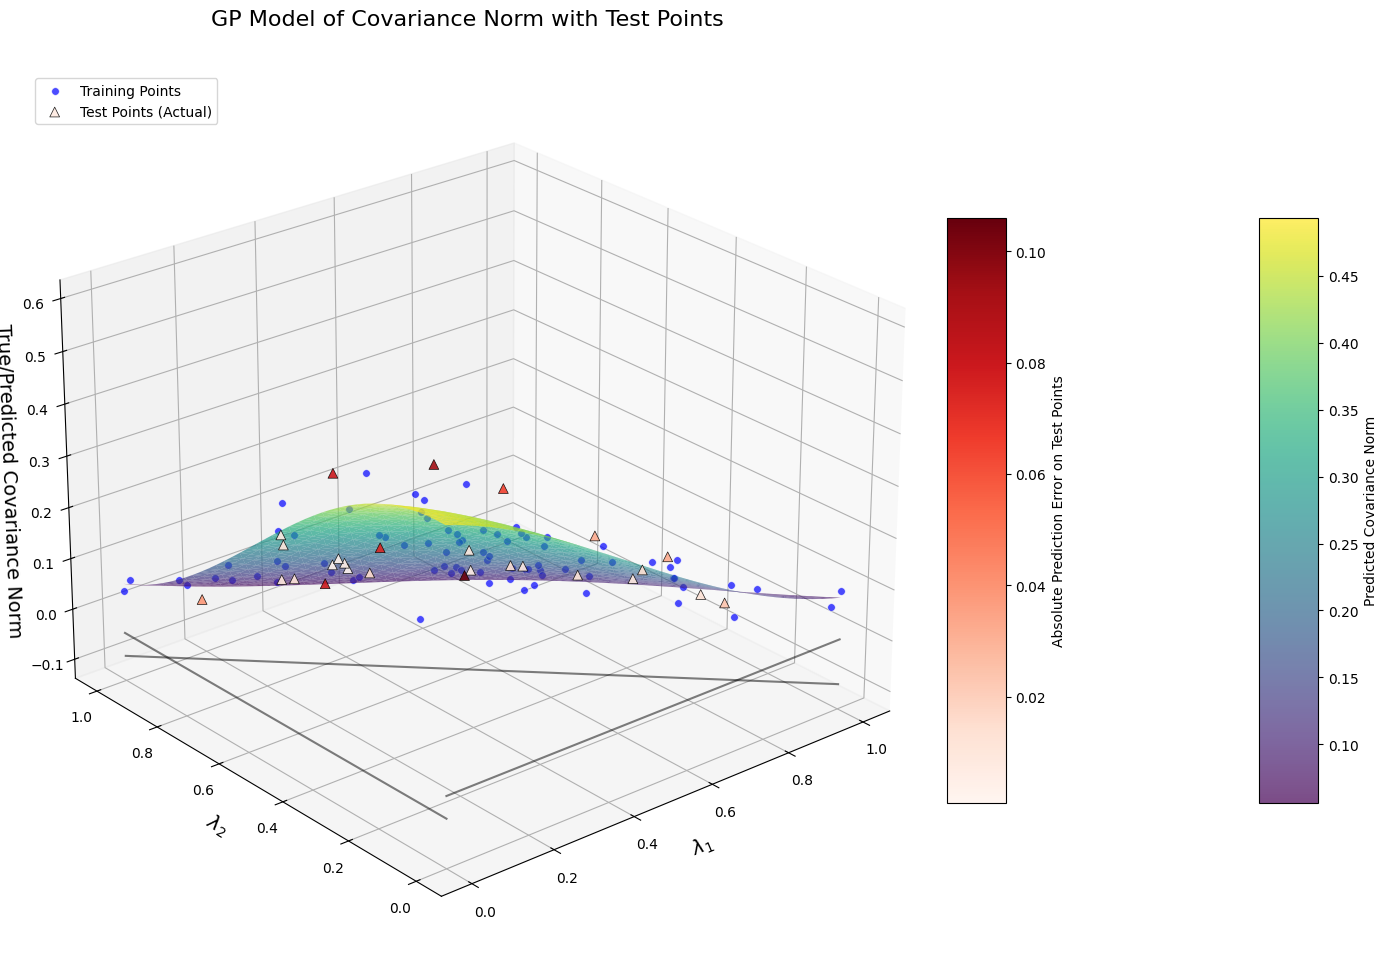


Generating True vs. Predicted Plot...


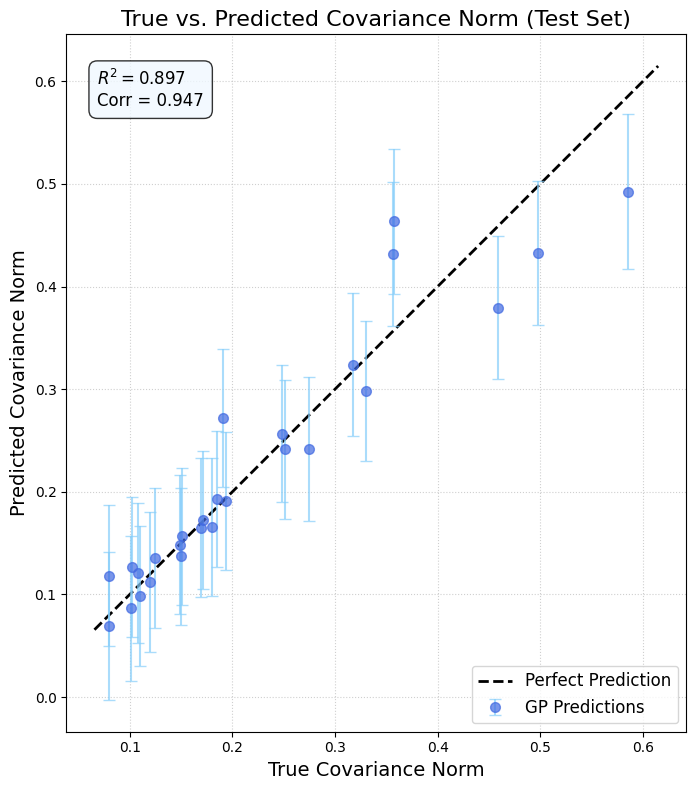

In [44]:
# Cell 15: Generate and Display Plots

if len(X_test) > 0: # Ensure there is test data to plot
    print("\nGenerating 3D GP Surface Plot...")
    fig3d = plot_gp_surface_with_test_points_enhanced(
        gp_model,
        X_train, y_train, # Original unscaled training data
        X_test, y_test,   # Original unscaled test data
        y_pred,           # Unscaled predictions for test data
        test_errors,      # Absolute errors for test data
        scaler_X, scaler_y, # Fitted scalers
        title_suffix="Covariance Norm"
    )

    print("\nGenerating True vs. Predicted Plot...")
    fig2d = plot_true_vs_predicted_enhanced(
        y_test, y_pred, y_std, # Unscaled true, predicted, and std_dev for test data
        title_suffix="Covariance Norm"
    )
else:
    print("Skipping plots as there is no test data (or too few overall data points).")